# Connecting to Drive 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading The Dataset

In [3]:
import zipfile
import os

# Define the path to the zip file
zip_file_path = '/content/drive/My Drive/archive.zip'

# Define the directory where you want to extract the files
extracted_dir_path = '/content/drive/My Drive/extracted_images/'

# Create the directory if it doesn't exist
os.makedirs(extracted_dir_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

print("Extraction complete.")


Extraction complete.


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/extracted_images/archive/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/extracted_images/archive/train/Positive/00002.jpg
/content/drive/MyDrive/extracted_images/archive/train/Positive/00017.jpg
/content/drive/MyDrive/extracted_images/archive/train/Positive/00051.jpg
/content/drive/MyDrive/extracted_images/archive/train/Positive/00052.jpg
/content/drive/MyDrive/extracted_images/archive/train/Positive/00114.jpg
/content/drive/MyDrive/extracted_images/archive/train/Positive/00193.jpg
/content/drive/MyDrive/extracted_images/archive/train/Positive/00219.jpg
/content/drive/MyDrive/extracted_images/archive/train/Positive/00236.jpg
/content/drive/MyDrive/extracted_images/archive/train/Positive/00269.jpg
/content/drive/MyDrive/extracted_images/archive/train/Positive/00275.jpg
/content/drive/MyDrive/extracted_images/archive/train/Positive/00295.jpg
/content/drive/MyDrive/extracted_images/archive/train/Positive/00302.jpg
/content/drive/MyDrive/extracted_images/archive/train/Positive/00303.jpg


# Importing the required Libraries

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model,layers
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2

# Sample Visualization from Dataset

In [6]:
# Let's create a function to see some images

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
        if len(images)>3:
            break
    fig=plt.figure(figsize=(10,12))
    xrange=range(1,5)

    for img,x in zip(images,xrange):
        ax=fig.add_subplot(2,2,x)
        ax.imshow(img)
        ax.set_title(img.shape)

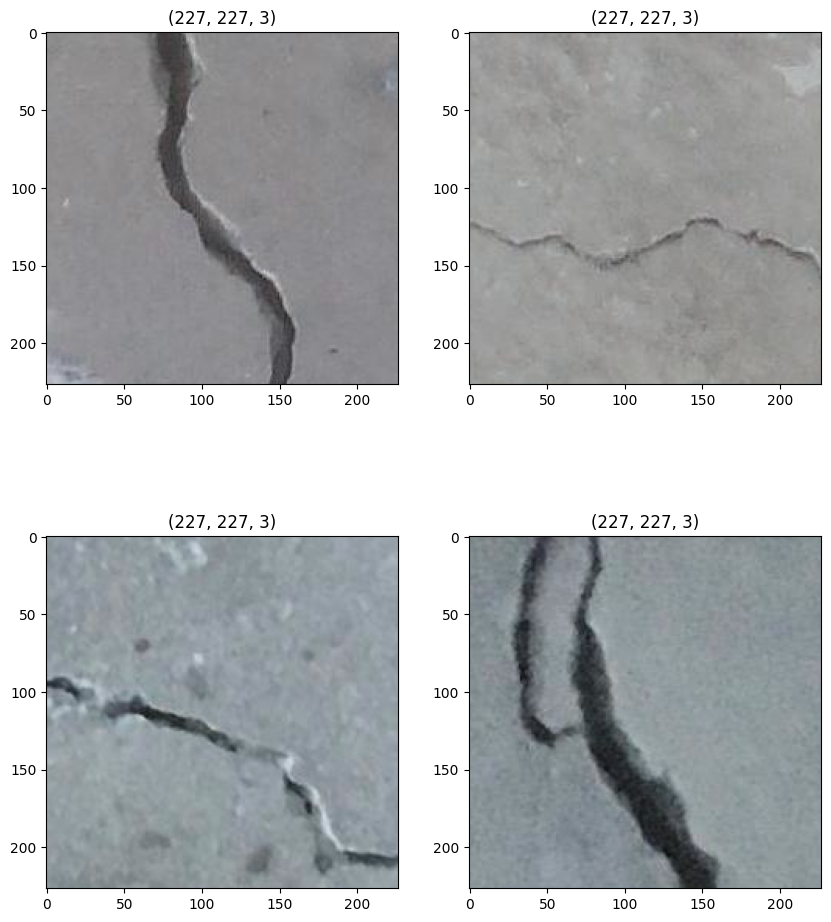

In [7]:
load_images_from_folder("/content/drive/MyDrive/extracted_images/archive/train/Positive")

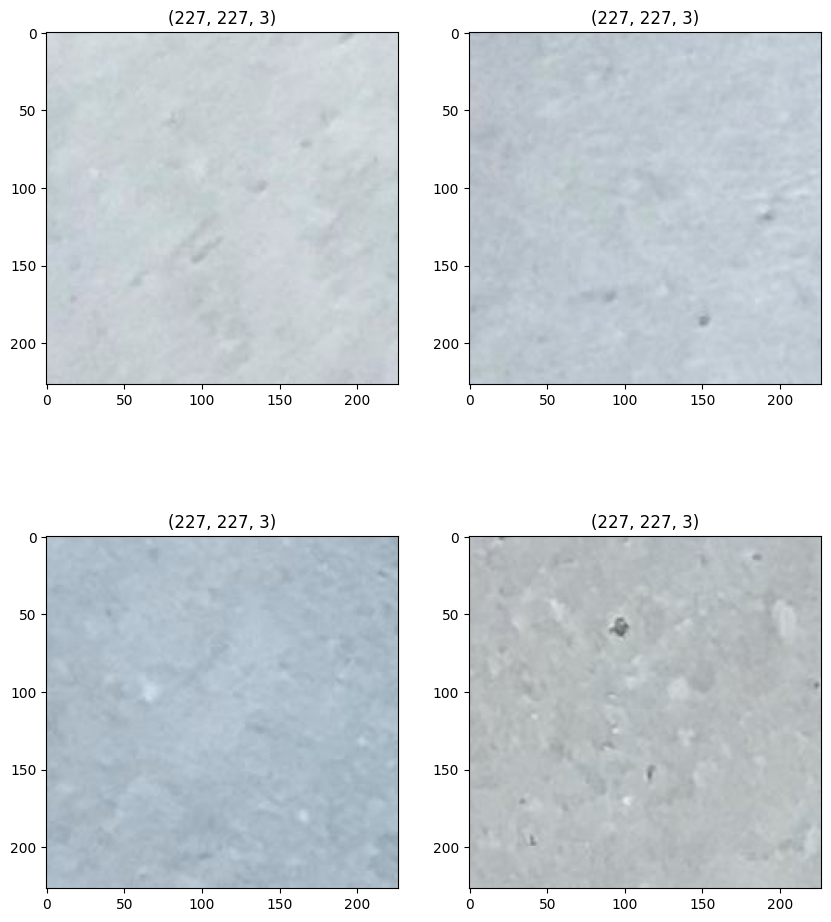

In [8]:
load_images_from_folder("/content/drive/MyDrive/extracted_images/archive/train/Negative")

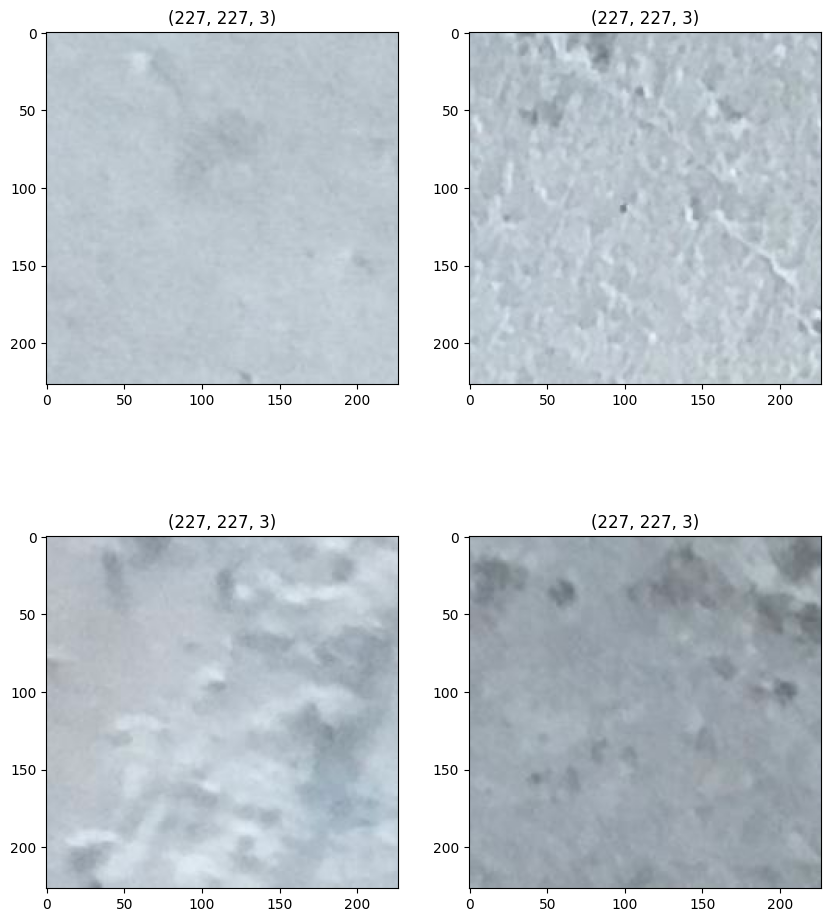

In [9]:
load_images_from_folder("/content/drive/MyDrive/extracted_images/archive/test/Negative")

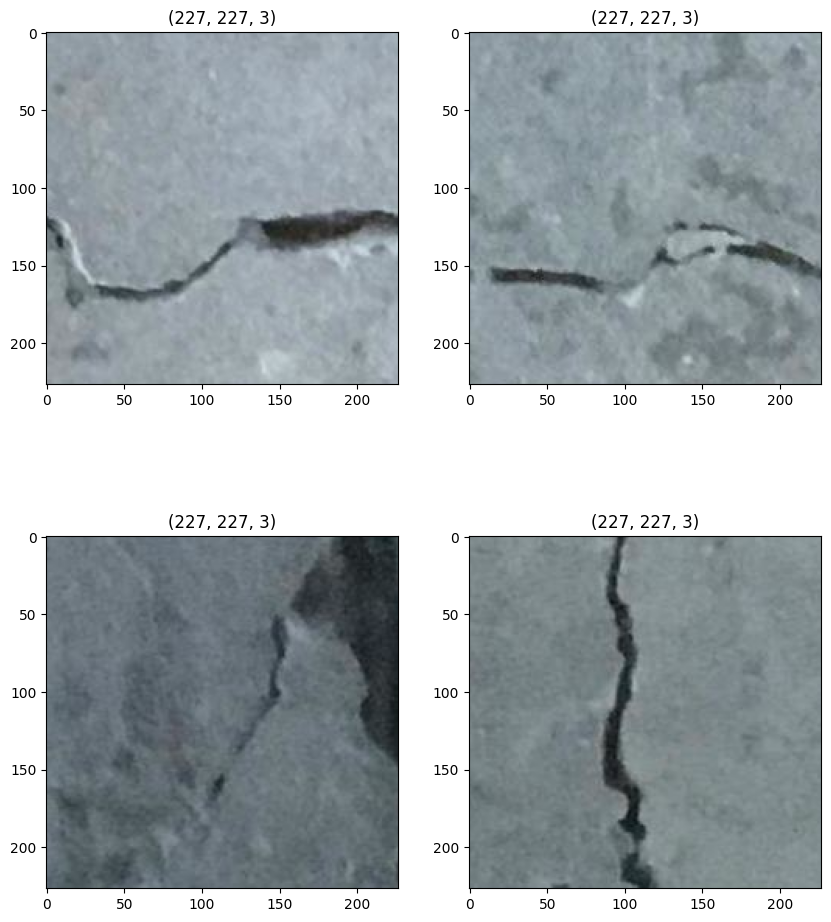

In [10]:
load_images_from_folder("/content/drive/MyDrive/extracted_images/archive/test/Positive")

# Data Preprocess Function 

In [11]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Sequential

# Preprocess your images
def preprocess_images(images):
    processed_images = []
    for img in images:
        img = cv2.resize(img, (224, 224))  # Resize image to 224x224
        img = preprocess_input(img)  # Preprocess image according to VGG16 requirements
        processed_images.append(img)
    return np.array(processed_images)

In [16]:
from keras.preprocessing.image import ImageDataGenerator

# Define directories for train and test data
train_dir = '/content/drive/MyDrive/extracted_images/archive/train'
test_dir = '/content/drive/MyDrive/extracted_images/archive/test'

# Define ImageDataGenerator for train and test data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.15)  # Splitting 15% of data for validation

# Define batch size
batch_size = 16

# Flow images from directory with validation split
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')  # Subset for training data

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')  # Subset for validation data


test_data_dir = '/content/drive/MyDrive/extracted_images/archive/test'

# Define the image size and batch size
image_size = (224, 224)

# Create the ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test generator
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',  # or 'categorical' if you have multiple classes
    shuffle=False  # Set shuffle to False for test data
)

Found 28900 images belonging to 2 classes.
Found 5100 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.


# DenseNet121 model 

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications import VGG16
from keras.applications import ResNet50
from keras.layers import Dense, Flatten, Dropout
from keras.applications import DenseNet121


# Load DenseNet121 model without the top (fully connected layers)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define number of training and validation steps
train_steps_per_epoch = train_generator.samples // batch_size
val_steps_per_epoch = validation_generator.samples // batch_size
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=val_steps_per_epoch
)

# Get training and validation loss and accuracy from history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Print the values
print("Training Loss:", training_loss)
print("Training Accuracy:", training_accuracy)
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/5
1806/1806 [==============================] - 220s 117ms/step - loss: 0.1185 - accuracy: 0.9926 - val_loss: 0.0167 - val_accuracy: 0.9980
Epoch 2/5
1806/1806 [==============================] - 206s 114ms/step - loss: 0.0188 - accuracy: 0.9978 - val_loss: 0.0075 - val_accuracy: 0.9990
Epoch 3/5
1806/1806 [==============================] - 206s 114ms/step - loss: 0.0118 - accuracy: 0.9980 - val_loss: 0.0201 - val_accuracy: 0.9963
Epoch 4/5
1806/1806 [==============================] - 210s 116ms/step - loss: 0.0092 - accuracy: 0.9985 - val_loss: 0.2896 - val_accuracy: 0.9847
Epoch 5/5
1806/1806 [==============================] - 206s 114ms/step - loss: 0.0169 - accuracy: 0.9985 - val_loss: 0.0133 - val_accuracy: 0.9980
Training Loss: [0.11847322434186935, 0.018771614879369736, 0.01179156918078661, 0.009242603555321693, 0.016882143914699554]
Training Accuracy: [0.9925910830497742, 0.9977842569351196, 0.99795734882354

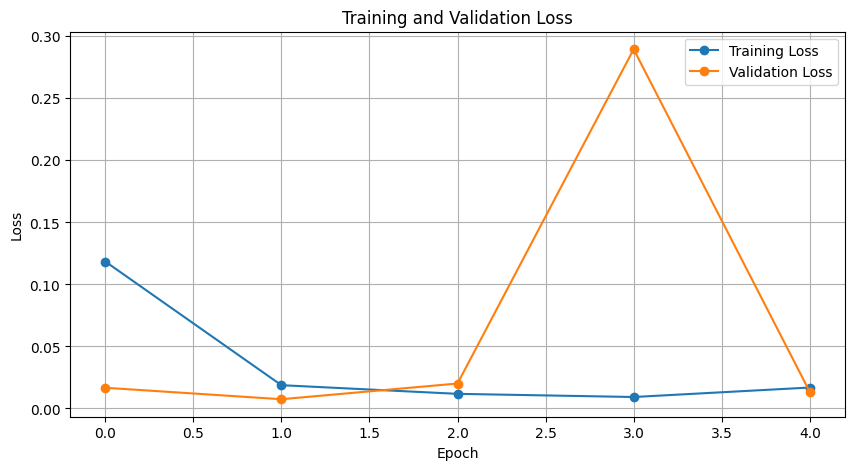

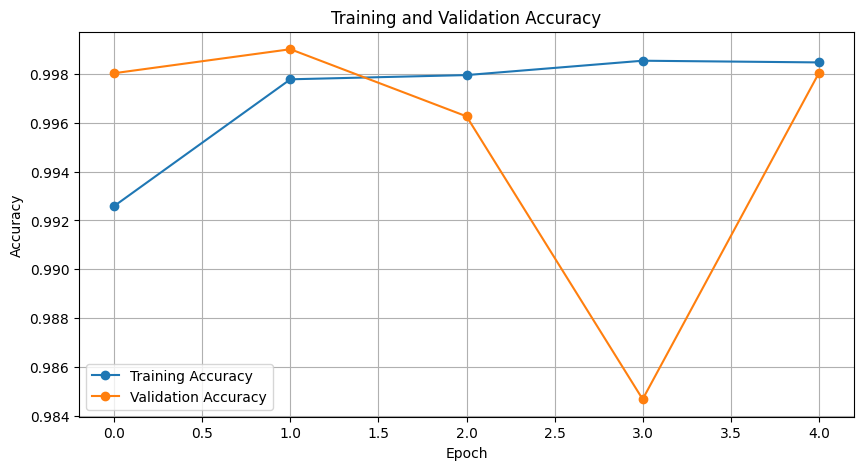

In [39]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [40]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_9[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']